# HOMEWORK 2
For this homework you will have to complete and implement the colour balancing for:
* Gray world algorithm
* Scale-by-max algorithm

You are free to use your own images. Experiment with more images and think about the effect each of the algorithms has on the resulting (balanced) image.

### Colour Balancing
In this notebook we will show different type of colour balancing making use of von Kries' hypothesis.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

# Plot number of images with titles histograms
def plot_with_histograms(plots: list[tuple[str, np.ndarray]]):
    n = len(plots)
    plt.figure(figsize=(15, 5 * n))
    for i, (name, img) in enumerate(plots):
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img)

        plt.title(name)
        plt.axis("off")
        plt.subplot(n, 2, 2 * i + 2)
        plt.title("Histogram")
        plt.xlim([0, 256])
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        colors = ["red", "green", "blue"]
        for idx, color in enumerate(colors):
            plt.hist(img[..., idx].ravel(), bins=256, color=color, alpha=0.5, label=color)

    plt.tight_layout()
    plt.show()


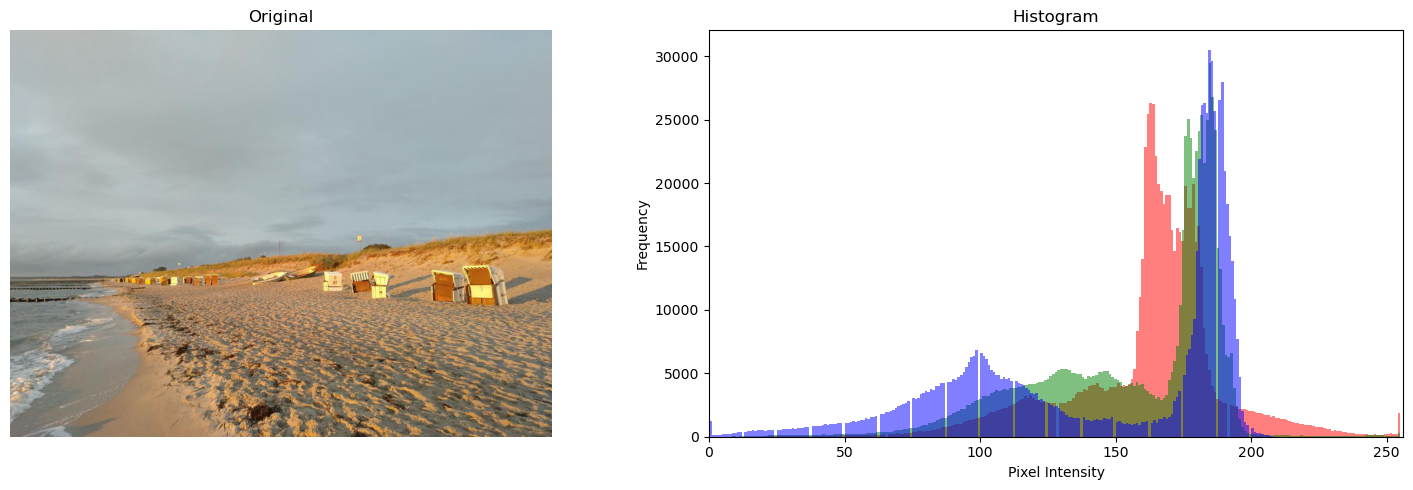

In [2]:
img = cv2.imread('./data/sea.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_with_histograms([("Original", img)])

### White patch
In white patch algorithm we choose a group of pixels we know they should be white. We then scale the resulting image colour channels by this white patch.

In [3]:
# Define white patch and the coefficients
row, col = 485, 864
white = img[row, col, :]
coeffs = 255.0/white

print(f'{coeffs=}')

def apply_white_balance_f32(img, coeffs):
    result = np.empty_like(img, dtype=np.float32)
    for channel in range(3):
        result[..., channel] = img[..., channel] * coeffs[channel]
    result[result > 255] = 255
    return result.astype(img.dtype)

def apply_white_balance_u16(img, coeffs):
    result = np.empty_like(img, dtype=np.uint16)
    for channel in range(3):
        result[..., channel] = img[..., channel] * coeffs[channel]
    result[result > 255] = 255
    return result.astype(img.dtype)

def apply_white_balance_opt(img, coeffs):
    result = img.astype(np.float32) * coeffs
    result = np.clip(result, 0, 255)
    return result.astype(img.dtype)

# Example usage:
balanced_opt = apply_white_balance_opt(img, coeffs)
balanced_f32 = apply_white_balance_f32(img, coeffs)
balanced_u16 = apply_white_balance_u16(img, coeffs)


coeffs=array([1.01190476, 1.05371901, 2.00787402])


In [4]:
%%timeit -n 100

# 5.2ms
apply_white_balance_f32(img, coeffs)

7.46 ms ± 134 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit -n 100

# 4.4ms
apply_white_balance_u16(img, coeffs)

6.31 ms ± 339 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit -n 100

# 7.2ms - WHY???
apply_white_balance_opt(img, coeffs)

8.91 ms ± 133 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


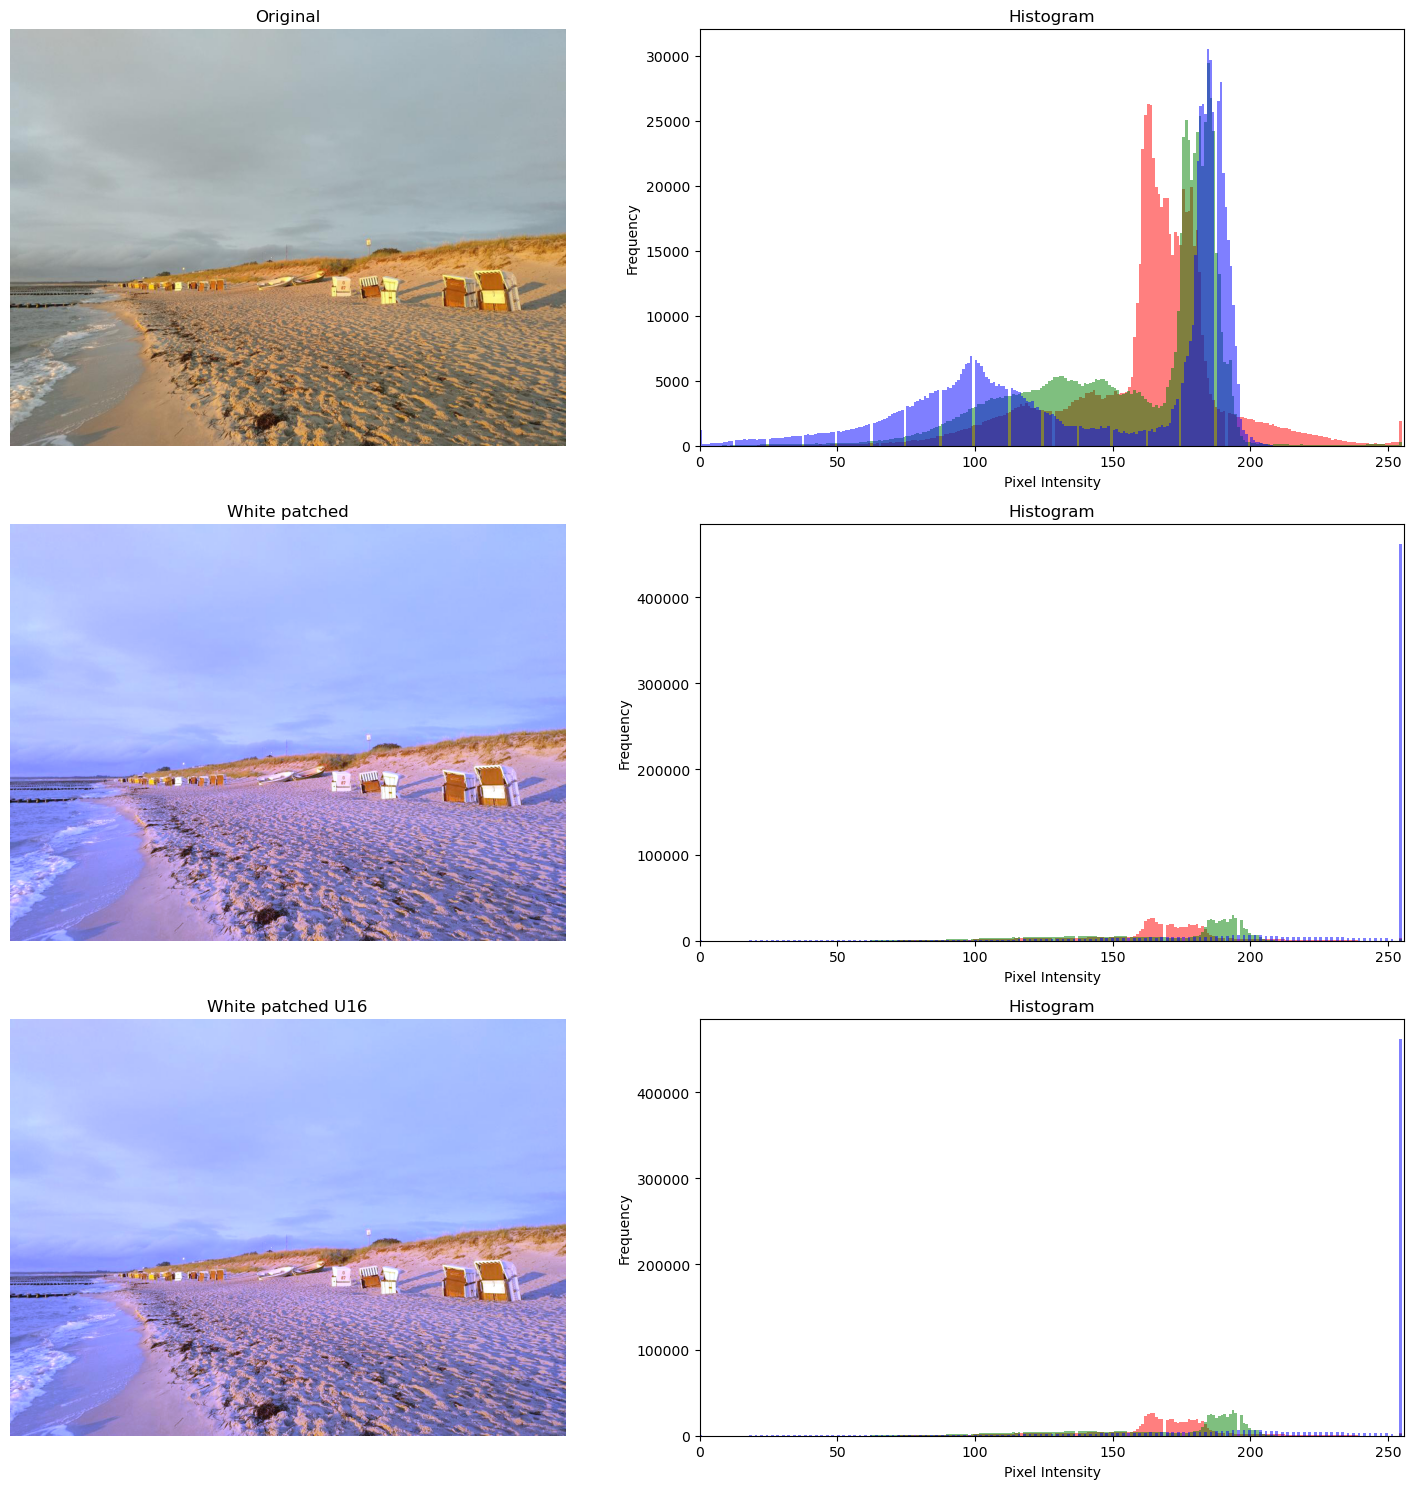

In [7]:
plot_with_histograms([("Original", img), ("White patched", balanced_f32), ("White patched U16", balanced_u16)])

### Gray world
This algorithm assumes that a scene, on average, is gray.

mean_r=np.float64(162.25943903796087), mean_g=np.float64(156.8133752729487), mean_b=np.float64(144.08029809145881)


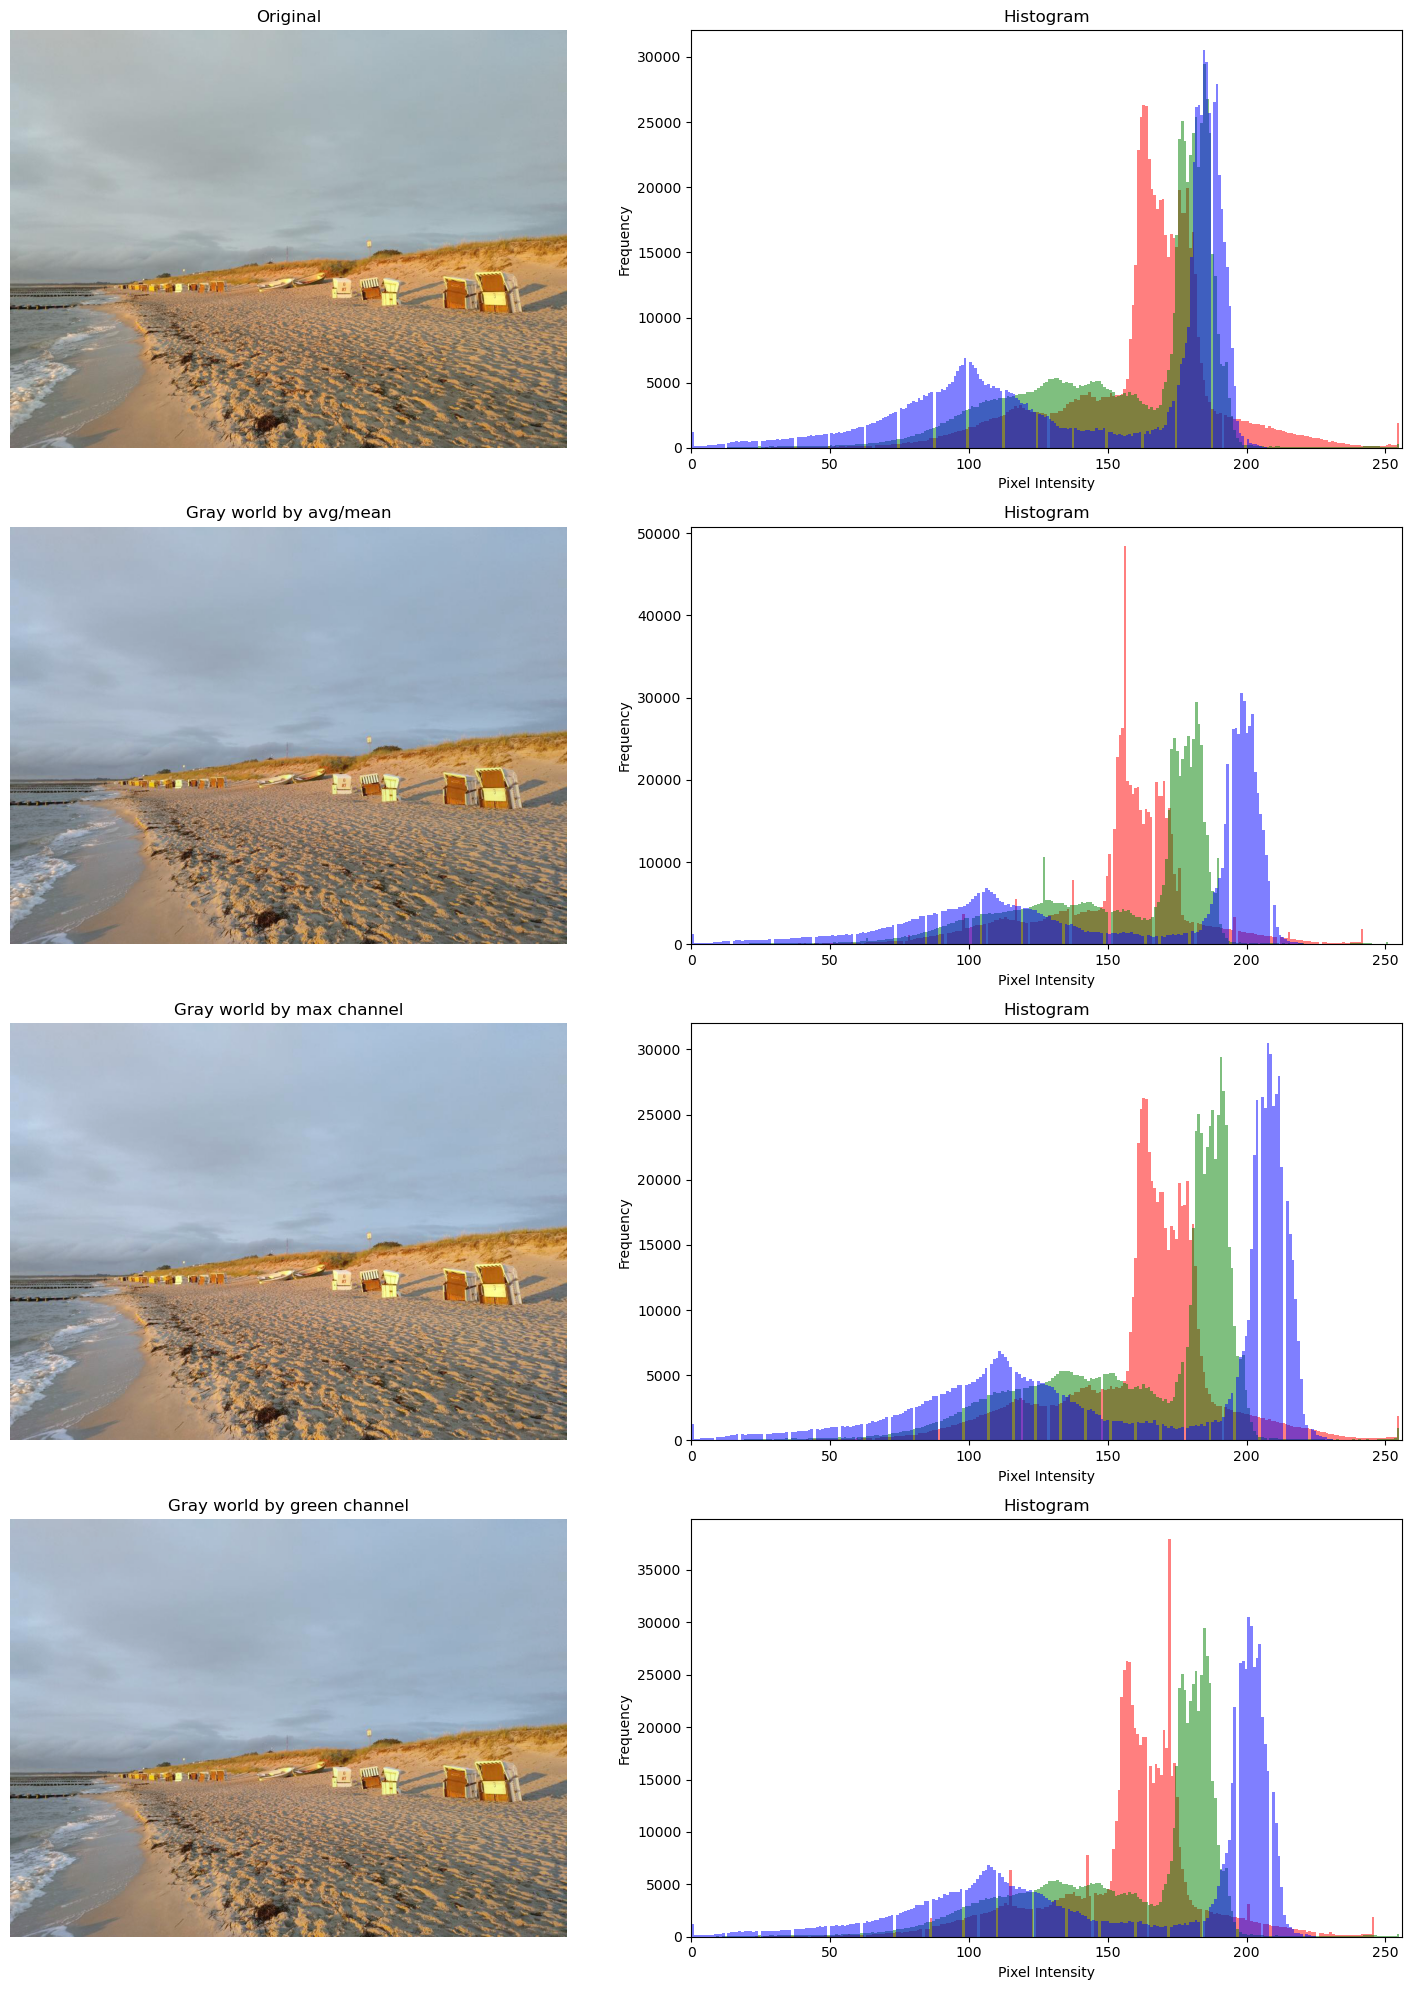

In [8]:
# Load your image
img = cv2.imread("./data/sea.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Compute the mean values for all three colour channels (red, green, blue)
mean_r = np.mean(img[..., 0])
mean_g = np.mean(img[..., 1])
mean_b = np.mean(img[..., 2])
mean_rgb = np.array([mean_r, mean_g, mean_b])

print(f"{mean_r=}, {mean_g=}, {mean_b=}")

# Compute the coefficients kr, kg, kb
# Note: there are 3 coefficients to compute but we only have 2 equations.
# Therefore, you have to make an assumption, fix the value of one of the
# coefficients and compute the remining two
# Hint: You can fix the coefficient of the brightest colour channel to 1.

avg_intensity = (mean_r + mean_g + mean_b) / 3.0

coeffs_gray = [
    (
        "Gray world by avg/mean",
        np.array([avg_intensity / mean_r, avg_intensity / mean_g, avg_intensity / mean_b]),
    ),
    (
        "Gray world by max channel",
        np.array(np.max(mean_rgb) / mean_rgb),
    ),
    (
        "Gray world by green channel",
        np.array([mean_g / mean_r, 1, mean_g / mean_b]),
    ),
]

plots = [("Original", img)]

for name, coeffs in coeffs_gray:
    balanced = np.empty_like(img, dtype=np.float32)
    for c in range(img.shape[2]):
        balanced[..., c] = img[..., c] * coeffs[c]
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)
    plots.append((name, balanced))


plot_with_histograms(plots)

### Scale-by-max
This is a straightforward algorithm that scales each colour channel by its maximum value. Note that it is sensitive to noise and saturations.

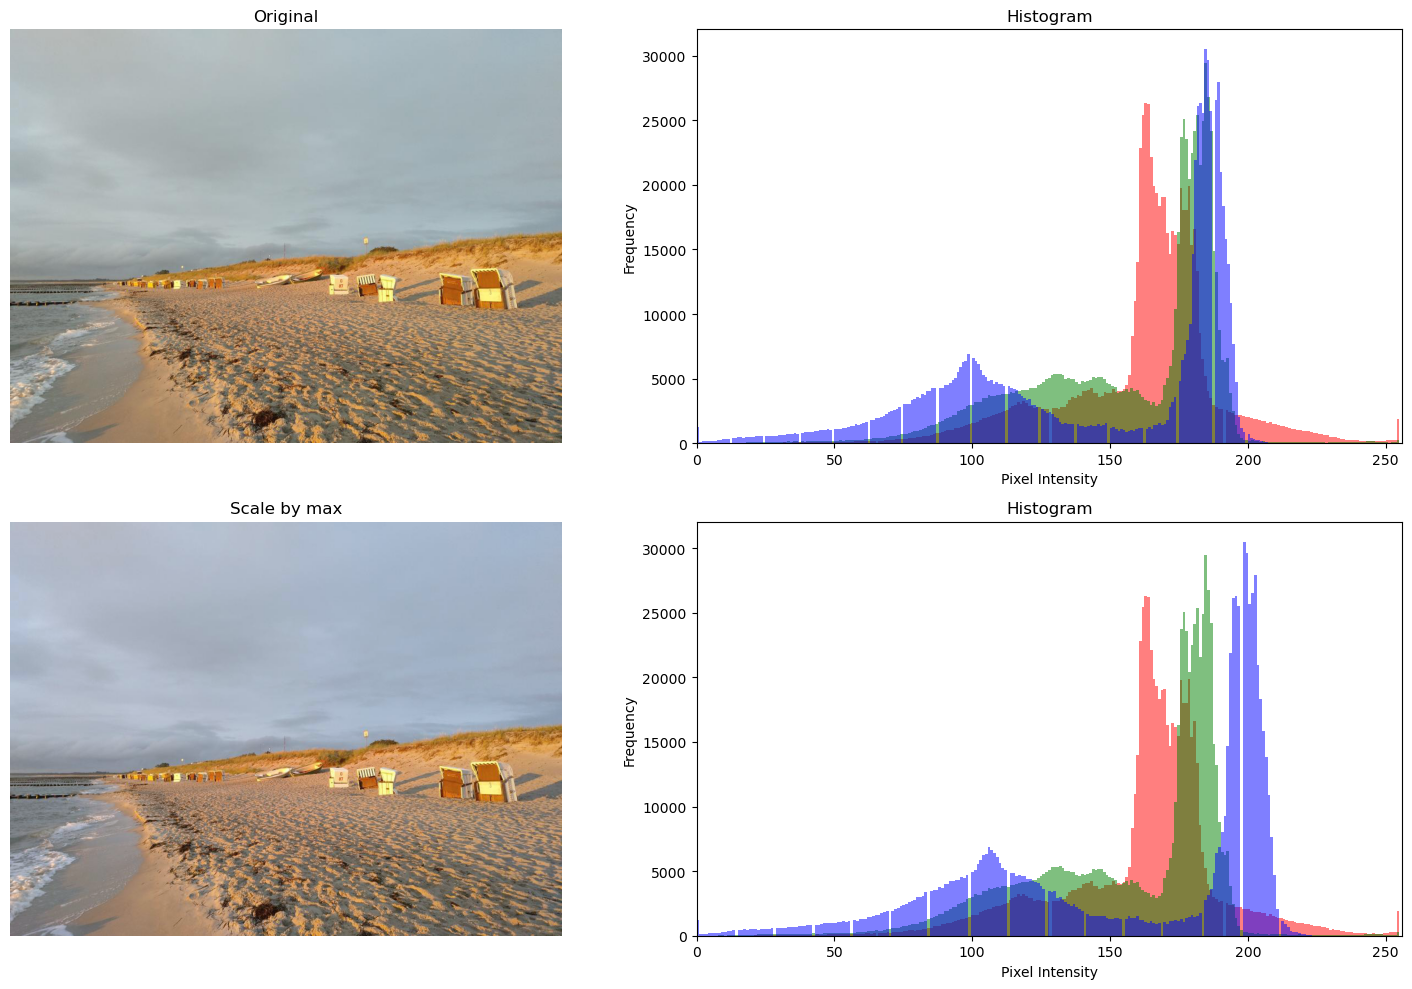

In [9]:
# Load your image
img = cv2.imread('./data/sea.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Compute the maximum values for all three colour channels (red, green, blue)
max_r = np.max(img[..., 0])
max_g = np.max(img[..., 1])
max_b = np.max(img[..., 2])

# Apply scale-by-max balancing and generate the balanced image
balanced = img * (np.array([255, 255, 255]) / np.array([max_r, max_g, max_b]))
balanced = np.clip(balanced, 0, 255).astype(np.uint8)

plot_with_histograms([("Original", img), ("Scale by max", balanced)])